In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# setting the working directory
os.chdir('C:/Users/spijak/Downloads/')

# importing data
df = pd.read_csv('data_predikce_SU.csv')

#loading first 5 rows of the dataset
df.head()

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Data pre-processing

Before we can use the dataset for building any prediction model, we need to make sure our data is clean and does not contain any unwanted values, i.e. null values or wrong values. Additionally, it is important we get to know the dataset and possibly correct the datatypes of each variable. This cleaning process will be done in the following section.

In [ ]:
# quick overview of missing data and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         45211 non-null  int64  
 1   age        45202 non-null  float64
 2   job        45211 non-null  object 
 3   marital    45211 non-null  object 
 4   education  45211 non-null  object 
 5   default    45211 non-null  object 
 6   balance    45208 non-null  float64
 7   housing    45211 non-null  object 
 8   loan       45211 non-null  object 
 9   contact    45211 non-null  object 
 10  day        45211 non-null  int64  
 11  month      45211 non-null  object 
 12  duration   45211 non-null  int64  
 13  campaign   45211 non-null  int64  
 14  pdays      45211 non-null  int64  
 15  previous   45211 non-null  int64  
 16  poutcome   45211 non-null  object 
 17  y          45211 non-null  object 
dtypes: float64(2), int64(6), object(10)
memory usage: 6.2+ MB


### Removing null values

In [ ]:
# printing the percentage of missing values for age and balance variables
print('Missing values of columns (in %)\n\nage: '+str(round((df['age'].isna().sum()/len(df))*100, 5)) +
     '\nbalance: '+str(round((df['balance'].isna().sum()/len(df))*100, 5)))

Missing values of columns (in %)

age: 0.01991
balance: 0.00664


Upon first inspection, we can see that the dataset contains **45211** observations and columns **age** and **balance** are missing some values, **9** and **3** respectively. Usually, it is a good practice to first understand what is the reason of this by looking at the rows with missing data. However, due to the fact that only less than **0.02%** and **0.01%** values for age and balance columns are missing we can drop these rows without any impact on the size of the dataset.

In [ ]:
# dropping rows with missing values
df_clean = df.dropna().reset_index(drop=True)

# printing basic summary statistics
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,45200.0,23611.490686,13048.276539,1001.0,12311.75,23611.5,34911.25,46211.0
age,45200.0,40.954292,11.539117,-1.0,33.00,39.0,48.00,999.0
balance,45200.0,1362.565686,3045.076372,-8019.0,72.00,449.0,1428.00,102127.0
day,45200.0,15.809049,8.321781,1.0,8.00,16.0,21.00,31.0
duration,45200.0,258.141637,257.438318,0.0,103.00,180.0,319.00,4918.0
campaign,45200.0,2.764270,3.098276,1.0,1.00,2.0,3.00,63.0
pdays,45200.0,40.207854,100.138866,-1.0,-1.00,-1.0,-1.00,871.0
previous,45200.0,0.580465,2.303704,0.0,0.00,0.0,0.00,275.0


When looking at the basic summary statistics, we can see that the **age** variable contains slightly weird values, **-1** or **999** are obviously not correct age values of the customers. To get a better understanding of how many rows this affects, we can subset the dataset and find it out.

In [ ]:
# filtering the dataset to find wrong data
df_clean[(df_clean['age'] < 1) | (df_clean['age'] > 100)]

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1001,999.0,management,married,tertiary,no,2143.0,yes,no,unknown,5,may,261,1,-1,0,unknown,no
45192,46204,-1.0,student,single,tertiary,no,113.0,no,no,cellular,17,nov,266,1,-1,0,unknown,yes
45193,46205,-1.0,retired,married,secondary,no,2850.0,no,no,cellular,17,nov,300,1,40,8,failure,yes
45194,46206,-1.0,technician,single,secondary,no,505.0,no,yes,cellular,17,nov,386,2,-1,0,unknown,yes


Again, this affects only a negligible amount of rows so we can drop these observations.

In [ ]:
# dropping rows with wrong age values
df_clean = df_clean[(df_clean['age'] > 1) & (df_clean['age'] < 100)]
df_clean

,Id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
1,1002,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,1003,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,1004,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,1005,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,1006,35.0,management,married,tertiary,no,231.0,yes,no,unknown,5,may,139,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45195,46207,51.0,technician,married,tertiary,no,825.0,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45196,46208,71.0,retired,divorced,primary,no,1729.0,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45197,46209,72.0,retired,married,secondary,no,5715.0,no,no,cellular,17,nov,1127,5,184,3,success,yes
45198,46210,57.0,blue-collar,married,secondary,no,668.0,no,no,telephone,17,nov,508,4,-1,0,unknown,no


### Treating outliers

We need to also make sure that some variables do not have high variance. Two potential offenders of this issue could be columns **balance** and **duration**. Having extremely outlying values could bias the model results. We can check the outliers using a boxplot. However, sometimes outliers may contain valuable information or indicate interesting patterns.

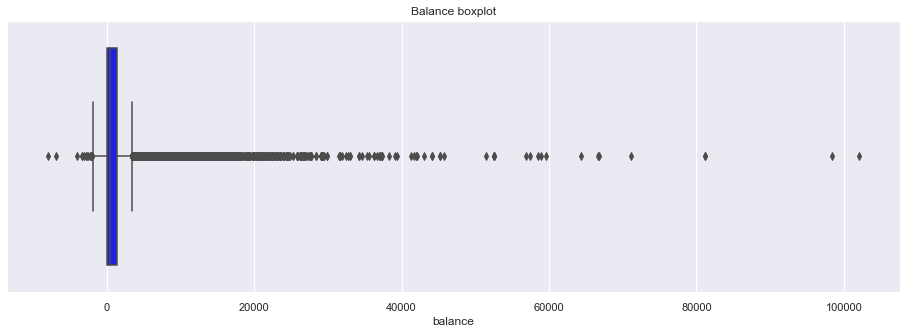

In [ ]:
# plotting the balance boxplot
sns.set_theme()
fig, ax = plt.subplots(figsize=(16,5))
sns.boxplot(data=df_clean, x='balance', color='blue', ax=ax)
plt.title('Balance boxplot')
plt.show()

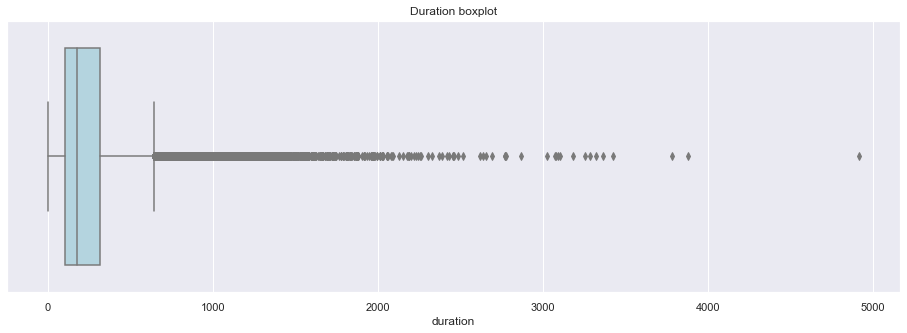

In [ ]:
# plotting the duration boxplot
fig, ax = plt.subplots(figsize=(16,5))
sns.boxplot(data=df_clean, x='duration', color='lightblue', ax=ax)
plt.title('Duration boxplot')
plt.show()

Both variables **balance** and **duration** have considerable amount of outliers, removing outliers is often the case, however I shall not remove them to preserve valuable information.

### Category label encoding

The model can only take in numerical values, therefore we need to encode the variables with string values to numerical categories. This approach shall be used for all columns containing string values.

We first find out how many unique values belong to each non-numerical category.

In [ ]:
# finding out how many unique values belong to each non-numerical category
non_numeric = df_clean.select_dtypes(exclude=[float, int]).columns
df_clean[non_numeric].nunique()

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
y             2
dtype: int64

Variables with 2 unique values can be converted using a classical label encoder. For the remaining variables we need to be careful, as encoding assigns the values in an order, causing the algorithm to misinterpret the value as it assigns more weight to higher order values. This makes sense in case of ordinal categories, however some categories contain values that cannot be ordered in any way. In that case, we can convert these variables to dummies.

In [ ]:
# function used to show the which code maps to which category
def encoding_info(col):
    code = df_clean[col].astype('category').cat.codes
    category = df_clean[col].astype('category')
    mapping = dict(zip(code, category))

    return mapping

# function used to convert columns to numeric dtype category
def encoding(data, col):
    for i in col:
        data[i] = data[i].astype('category').cat.codes

# function used to convert the non-numeric category to numeric
def encoding_multiple(data, col, val_list):
        data[col] = data[col].astype('category')
        data[col] = data[col].cat.reorder_categories(
            new_categories = val_list,
            ordered=True)

        data[col] = data[col].cat.codes

Using the function, we can check what numeric code has been assinged to what class within the variables.

In [ ]:
encoding_info('housing')

{1: 'yes', 0: 'no'}

In [ ]:
encoding_info('loan')

{0: 'no', 1: 'yes'}

In [ ]:
encoding_info('y')

{0: 'no', 1: 'yes'}

In [ ]:
# encoding the category variables using the function
encoding(df_clean, ('default', 'housing', 'loan', 'y', 'marital'))

In [ ]:
# encoding the education variable
encoding_multiple(df_clean, 'education', ['unknown', 'primary', 'secondary', 'tertiary'])

# encoding the poutcome variable
encoding_multiple(df_clean, 'poutcome', ['failure', 'unknown', 'other', 'success'])

# encoding the month variable
encoding_multiple(df_clean, 'month', ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

The job variable is the exact case of an unordered category, as we cannot objectively order the jobs. In that case, we converted the column to multiple dummy variables so that the model does not misinterpret the order of the variable.

In [ ]:
# instance of one-hot encoder for job variable
df_final = pd.get_dummies(df_clean, columns=['job', 'contact'])

# converting bool dtype columns to int
bool_col = df_final.select_dtypes(include=[bool]).columns

# final preprocessed dataset
df_final[bool_col] = df_final[bool_col].astype(int)
df_final

,Id,age,marital,education,default,balance,housing,loan,day,month,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown
1,1002,44.0,2,2,0,29.0,1,0,5,4,...,0,0,0,0,1,0,0,0,0,1
2,1003,33.0,1,2,0,2.0,1,1,5,4,...,0,0,0,0,0,0,0,0,0,1
3,1004,47.0,1,0,0,1506.0,1,0,5,4,...,0,0,0,0,0,0,0,0,0,1
4,1005,33.0,2,0,0,1.0,0,0,5,4,...,0,0,0,0,0,0,1,0,0,1
5,1006,35.0,1,3,0,231.0,1,0,5,4,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45195,46207,51.0,1,3,0,825.0,0,0,17,10,...,0,0,0,0,1,0,0,1,0,0
45196,46208,71.0,0,1,0,1729.0,0,0,17,10,...,1,0,0,0,0,0,0,1,0,0
45197,46209,72.0,1,2,0,5715.0,0,0,17,10,...,1,0,0,0,0,0,0,1,0,0
45198,46210,57.0,1,2,0,668.0,0,0,17,10,...,0,0,0,0,0,0,0,0,1,0


## Initial exploratory data analysis

As a first step after cleaning the dataset, it is useful to uncover any potential relationships between the variables. The measure is the Pearson's correlation coefficient, which tracks the pair-wise linear relationships. A good way to visualize these relationships is through the heatmap. As seen in the following visual.

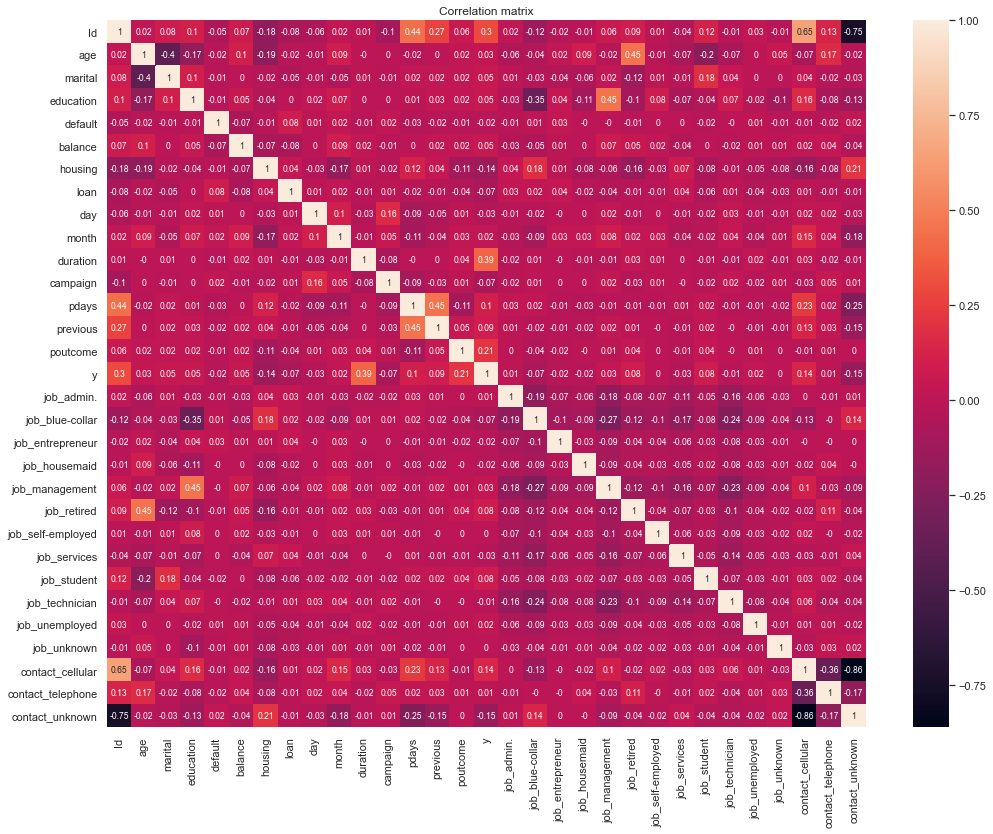

In [ ]:
matrix = df_final.corr()

fig, ax = plt.subplots(figsize=(17, 13))
fig = sns.heatmap(matrix.round(2), annot = True, annot_kws={'size': 8.5})
plt.title('Correlation matrix')
plt.show()

Upon first inspection, there is just one highly correlated pair of variables, **contact_unknown** and **id**. This may indicate that the clients are being contacted systematically from lower client's id to higher ones. Apart from this pair there are no notably high pairwise relationships. It is important to uncover any highly correlated pairs as including both in the model would bias our results. However, the correlation matrix only shows linear relationship.

In the this following section, I explore the relationship and summary statistics of various variables.

In [ ]:
# grouping the education by average balance and average duration
df_final.groupby('education').mean()

,Id,age,marital,default,balance,housing,loan,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown
education,,,,,,,,,,,,,,,,,,,,,
0,23175.835580,44.511590,1.192992,0.017251,1528.222642,0.440970,0.071698,15.822642,4.970350,257.484636,...,0.064151,0.021024,0.080863,0.087871,0.130458,0.015633,0.068464,0.533693,0.102426,0.363881
1,21502.141188,45.863776,1.014747,0.018543,1251.271426,0.568258,0.149511,15.424442,4.994014,255.740838,...,0.115929,0.018981,0.050226,0.006424,0.023069,0.037524,0.007446,0.520952,0.105417,0.373631
2,23015.853041,39.963961,1.163728,0.019744,1154.967237,0.605035,0.185412,15.760443,5.027374,258.669397,...,0.042376,0.024874,0.149028,0.021899,0.225288,0.031383,0.003061,0.633099,0.058844,0.308057
3,25794.786010,39.594133,1.249643,0.014818,1758.989996,0.479428,0.134111,16.090636,5.451147,258.535690,...,0.027529,0.062655,0.015194,0.016698,0.148026,0.021737,0.002933,0.755021,0.047311,0.197668


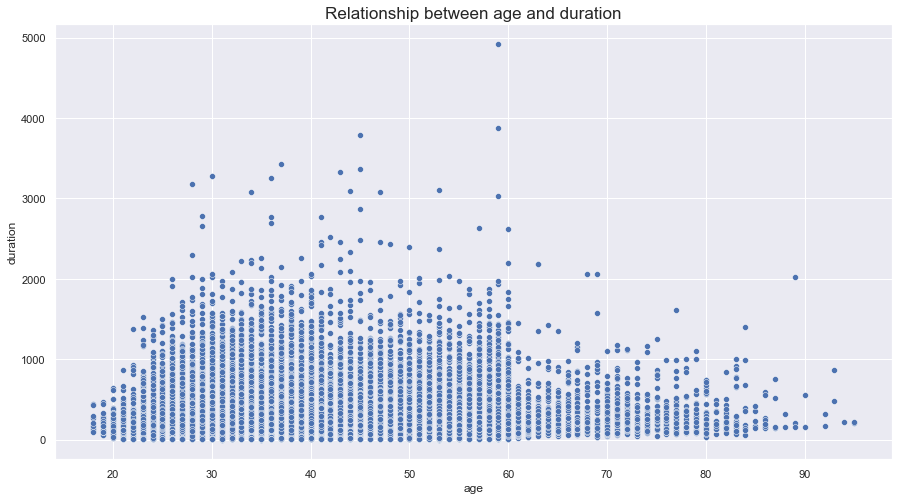

In [ ]:
# plotting a scatter plot with relationship between age and duration
fig_1, ax_1 = plt.subplots(figsize=(15, 8))
fig_1 = sns.scatterplot(data=df_final, x='age', y='duration', ax=ax_1)
plt.title('Relationship between age and duration', fontsize=17)
plt.show()

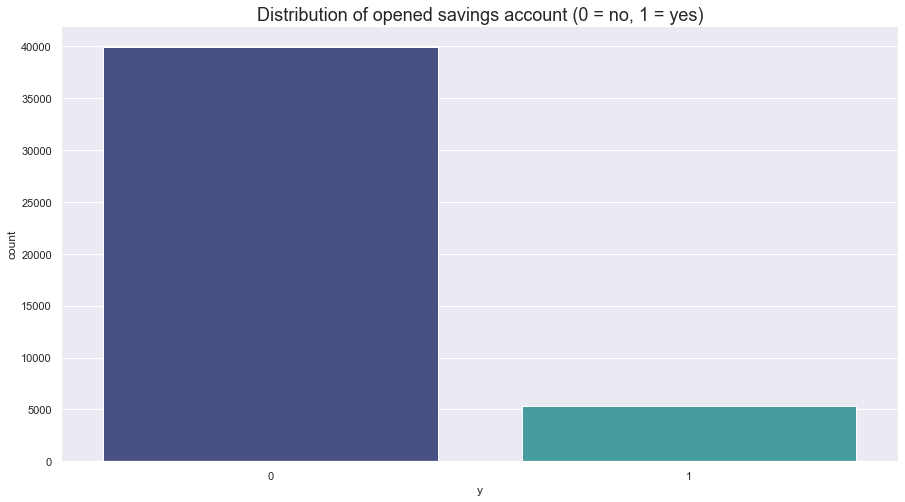

In [ ]:
#visualizing the explanatory variable
sns.set_theme()
fig_2, ax_2 = plt.subplots(figsize=(15, 8))
fig_2 = sns.countplot(data=df_final, x='y', palette='mako', ax=ax_2)
plt.title('Distribution of opened savings account (0 = no, 1 = yes)', fontsize=18)
plt.show()

We can see that the classes of the **Y** variable are imbalanced, which would cause our model to incorrectly predict the **yes** feature as it is underrepresented in the dataset. This issue can be treated by either undersampling or oversampling. We will go with oversampling technique as undersampling could cause a loss of information.

## Prediction

Predicting whether a customer/client opens a savings account is a binary classification problem. One of the best algorithms for this type of task is the Logistic Regression, Random Forest or K-Nearest Neighbors. For the purpose of our analysis, **I went with Logistic Regression**.

However, a good practice is to compare multiple approaches together and select the best performing model based on the task. The comparison can be done by measuring the results of the confusion matrix, i.e. the accuracy of the model and subsequently selecting the best performing model. Among useful comparison techniques, we have the **lazypredict** library, which is capable of comparing the results of models.

However, we first need to split our dataset into train and test sets. And after that we can oversample the training set.

In [ ]:
from sklearn.model_selection import train_test_split

# subsetting the predictor variables
X = df_final
Y = df_final['y']
X.drop('y', axis=1, inplace=True)

# splitting the dataset to 30% test and 70% train sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 21)

In [ ]:
# printing the dimensions of each set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31637, 30) (13559, 30) (31637,) (13559,)


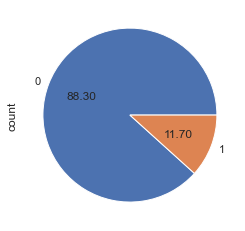

In [ ]:
# the percentage distribution of the target variable classes
Y.value_counts().plot.pie(autopct='%.2f')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# initialize the smote algorithm
smt = SMOTE(random_state = 21)

# fit target and predictor variable
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print('Original target variable counts:', Counter(y_train))
print('Resampled target variable counts:', Counter(y_train_sm))

Original target variable counts: Counter({0: 27927, 1: 3710})
Resampled target variable counts: Counter({0: 27927, 1: 27927})


In order to balance the minority class of the target variable, we employed an oversampling technique called SMOTE (Synthetic Minority Oversampling Technique). As seen in the output, the original dataset contained **27927** observations of clients, who have not opened a savings account and **3710** who have. Once the oversampling was done, both of the classes are matching in count and we can proceed with the model building.

### Feature selection

To predict whether a customer opens a savings account, we shall be using only some variables from the dataset. Using the Recursive Feature Elimination method, we drop variables that do not perform well.

For the model, I have specified 20 most-performing features to be selected for the model.

In [ ]:
# logistic regression model preparation
log_mod = LogisticRegression(max_iter = 10000) #solver = 'lbfgs'

# recursive feature elimination
rfe = RFE(estimator = log_mod, n_features_to_select = 20)
rfe = rfe.fit(X_train_sm, y_train_sm)

In [ ]:
# printing the most important features
data_features = pd.DataFrame({
    'Feature':X_train_sm.columns,
    'Importance':rfe.ranking_},)

# ordering the features by importance
features = data_features.sort_values(by=['Importance']).reset_index(drop=True)
features
#list(features.Feature)

,Feature,Importance
0,poutcome,1
1,contact_cellular,1
2,job_unknown,1
3,job_unemployed,1
4,job_technician,1
5,job_student,1
6,job_services,1
7,job_self-employed,1
8,job_retired,1
9,job_management,1


We have to be sure to omit one of the dummy variables from the category, as we otherwise have a dummy variable trap. This issue needs to be addressed for **job** and **contact** variables.

In [ ]:
# specifying columns
cols = ['poutcome',
 'contact_cellular',
 #'job_unknown',
 'job_unemployed',
 'job_technician',
 'job_student',
 'job_services',
 'job_retired',
 'job_management',
 'job_housemaid',
 'job_entrepreneur',
 'job_blue-collar',
 'job_admin.',
 #'contact_unknown',
 'loan',
 'housing',
 'default',
 'marital',
 #'contact_telephone',
 'campaign',
 #'education',
 'previous',
 #'month',
 'age',
 #'day',
 'duration',
 'pdays',
 #'Id',
 'balance']

# subsetting only the important features
X_train_os_sub = X_train_sm[cols]
X_train_os_sub

,poutcome,contact_cellular,job_unemployed,job_technician,job_student,job_services,job_retired,job_management,job_housemaid,job_entrepreneur,...,loan,housing,default,marital,campaign,previous,age,duration,pdays,balance
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,48.000000,128,-1,268.000000
1,3,1,0,0,0,0,0,1,0,0,...,0,0,0,2,1,4,47.000000,253,97,86.000000
2,1,1,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,25.000000,352,-1,400.000000
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,4,0,28.000000,126,-1,-493.000000
4,1,0,0,0,0,0,0,1,0,0,...,0,1,0,2,1,0,35.000000,763,-1,565.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55849,2,1,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,34.859574,307,74,0.000000
55850,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,71.996158,185,-1,1128.980406
55851,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,3,0,48.730325,174,-1,759.647180
55852,1,0,0,0,0,0,0,0,0,0,...,0,1,0,1,2,0,40.507323,963,-1,-119.712377


### Model summary

In [ ]:
logit = sm.Logit(y_train_sm, X_train_os_sub)
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.264326
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.619     
Date:               2023-07-17 00:49 AIC:              29571.3125
No. Observations:   55854            BIC:              29767.7834
Df Model:           21               Log-Likelihood:   -14764.   
Df Residuals:       55832            LL-Null:          -38715.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     8.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
poutcome          0.6715   0.0231  29.0381 0.0000  0.6261  0.7168
contact_cellular  0.7375   0.0343  21.5241 0.0000  0.6704  0.8047
job_unemployed   -4.2533   0.1136 -37.4436 0.0000 -4.4759 -4.0306
job_technician   -3.6337   0.0529 -68.6390 0.0000 -3.7374 -3.5299
job_student      -2.8944   0.1011 -28.6204 0.0000 -3.0926 -2.6962
job_services     -4.0445   0.0770 -52.5050 0.0000 -4.1955 -3.8935
job_retired      -3.4403   0.0773 -44.5288 0.0000 -3.5917 -3.2889
job_management   -3.1661   0.0448 -70.6618 0.0000 -3.2539 -3.0783
job_housemaid    -4.8430   0.1468 -32.9983 0.0000 -5.1307 -4.5554
job_entrepreneur -4.3633   0.1347 -32.3984 0.0000 -4.6273 -4.0994
job_blue-collar  -3.7354   0.0527 -70.8286 0.0000 -3.8388 -3.6320
job_admin.       -3.4359   0.0600 -57.2525 0.0000 -3.5536 -3.3183
loan             -1.4530   0.0639 -22.7447 0.0000 -1.5782 -1.3278
housing          -1.4747   0.0345 -42.7232 0.0000 -1.5424 -1.4071
default          -1.2345   0.1913  -6.4534 0.0000 -1.6094 -0.8596
marital          -0.1505   0.0234  -6.4198 0.0000 -0.1964 -0.1045
campaign         -0.2046   0.0086 -23.7158 0.0000 -0.2216 -0.1877
previous          0.0306   0.0091   3.3788 0.0007  0.0129  0.0484
age               0.0086   0.0010   8.6536 0.0000  0.0067  0.0106
duration          0.0053   0.0001  79.6208 0.0000  0.0052  0.0055
pdays             0.0035   0.0002  20.7122 0.0000  0.0032  0.0039
balance           0.0000   0.0000   5.4024 0.0000  0.0000  0.0000
=================================================================

"""

We can see that all estimated coefficients have p-value smaller that 0.05, which means that the variables are statistically significant. The variables can be interpreted using the log-odds, which are calculated as an exponent of estimated coefficient.

Among variables with most positive impact on a customer opening a savings account, we have the poutcome and contact_cellular variables. If we start with the contact_cellular, we can claim that if the client was contacted on his mobile/cellular phone, given all other variables constant, it increases the chance of a client setting-up a savings account by **109%**, i.e. exp(0.7375). Same goes for the variable poutcome, if previous campaign was successful the chance goes up by **96%**.

In [ ]:
# building and fitting the model
logmodel = LogisticRegression(random_state=21, max_iter=10000)
logmodel.fit(X_train_os_sub, y_train_sm)

# accuracy of the model
print(logmodel.score(X_train_os_sub, y_train_sm))

0.8924159415619293


By fitting the model, we can see accuracy of the model, which is equal to **89.2%**. Additionally, the ROC curver shows how good the classifier is. The further the red line is from the blue dotted line the better. It basically tells us the trade-off between the true positive rate and the false positive rate for a binary classifier.

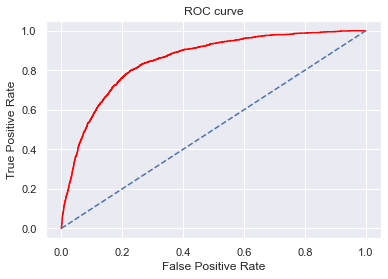

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# creating predictions and plotting the roc curve
pred = logmodel.predict_proba(X_test[cols])
prob_def = pred[:, 1]

fallout, sensitivity, thresholds = roc_curve(y_test, prob_def)
plt.plot(fallout, sensitivity, color ='red')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [ ]:
logmodel.score(X_test[cols], y_test)

0.8676156058706395

In [ ]:
# printing the classification report
y_pred = logmodel.predict(X_test[cols])
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     11983
           1       0.44      0.53      0.48      1576

    accuracy                           0.87     13559
   macro avg       0.69      0.72      0.70     13559
weighted avg       0.88      0.87      0.87     13559



We also ran the classification report to get a better overview of model performance and it's prediction power. The model is pretty good at identifying the clients, who did not open up a savings account. It tells us that 94% of the clients that did not open a savings account were correctly identified.

[[10924  1059]
 [  736   840]]


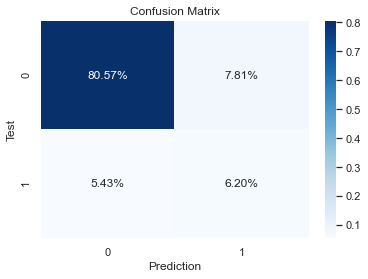

The model testing accuracy = 0.8676156058706395


In [ ]:
# specifying the confusion matrix
cm = confusion_matrix(y_test,y_pred)

# True-negative
TN = cm[0][0]

# False-negative
FN = cm[1][0]

#False-positive
FP = cm[0][1]

#True-negative
TP = cm[1][1]
print(cm)

sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Test')
plt.show()

print('The model testing accuracy = {}'.format((TP+TN)/(TP+TN+FN+FP)))

Using the confusion matrix we are able to describe the performance of a classification model on a set of test data for which the true values are known.

## Results summary

In order to predict whether a client opens a savings account or not, a **Logistic Regression** was employed. The model was based on dataset of **45 211** customers, while having a resulting accuracy of **87%**.

The most determining factors that affect the client's will to open a savings account are the previous successful campaigns and contacting the client on a mobile phone, the chance increases by **96%** and **109%** respectively. On the other hand, the chances of successfully arranging a savings account drop dramatically if the client has a **loan (by -78%)** or a **mortgage (by -77%)** or **defaulted (by -71%)** on of the payments in the past. Additionally, with every incremental contact regarding a specific campaign the more clients are less likely to open the account, as they feel overwhelmed.